### Importing Libraries and Required Models

In [1]:
import numpy as np
import pandas as pd

In [3]:
!pip install tensorflow_hub

  Obtaining dependency information for tensorflow_hub from https://files.pythonhosted.org/packages/6e/1a/fbae76f4057b9bcdf9468025d7a8ca952dec14bfafb9fc0b1e4244ce212f/tensorflow_hub-0.15.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 5.6 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
import tensorflow_hub as hub

In [5]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [6]:
import torch
import torch.nn as nn

In [7]:
torch.manual_seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

Using Tesla T4


In [8]:
def embed(input):
  return model(input)

### Importing Dataset

In [9]:
df = pd.read_csv('train.csv')

In [10]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [11]:
print(f"Initial dataframe has {len(df)} rows.")
null_rows = df[df.isnull().values.any(1)]
print(f"Dataframe has {len(null_rows)} null rows.")
df = df.dropna(how='any')
print(f"Dataframe has {len(df)} rows after removing null values.")

Initial dataframe has 404290 rows.
Dataframe has 3 null rows.
Dataframe has 404287 rows after removing null values.


In [12]:
q1_concat_q2 = pd.concat([df['question1'][:5], df['question2'][:5]])

question_embeddings = embed(q1_concat_q2)

In [13]:
# demo on first 5 questions
from sklearn.metrics.pairwise import cosine_similarity

question_embeddings = np.array(question_embeddings).tolist()

for i in range(5):
  q1_embedding = np.array(question_embeddings[i]).reshape(1, -1)
  q2_embedding = np.array(question_embeddings[i+5]).reshape(1, -1)

  q1 = df['question1'][i]
  q2 = df['question2'][i]

  print(f"Question 1: {q1}")
  print(f"Question 2: {q2}")

  cosine_sim = cosine_similarity(q1_embedding, q2_embedding)

  sim_score = cosine_sim[0][0]

  print(f"Similarity score: {sim_score:.4f}\n")

  # message_embedding_snippet = ", ".join((str(x) for x in message_embedding[:3]))
  # print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Question 1: What is the step by step guide to invest in share market in india?
Question 2: What is the step by step guide to invest in share market?
Similarity score: 0.9364

Question 1: What is the story of Kohinoor (Koh-i-Noor) Diamond?
Question 2: What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?
Similarity score: 0.6844

Question 1: How can I increase the speed of my internet connection while using a VPN?
Question 2: How can Internet speed be increased by hacking through DNS?
Similarity score: 0.6094

Question 1: Why am I mentally very lonely? How can I solve it?
Question 2: Find the remainder when [math]23^{24}[/math] is divided by 24,23?
Similarity score: 0.1250

Question 1: Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Question 2: Which fish would survive in salt water?
Similarity score: 0.3357



### Model Definition

In [ ]:
# class SiameseModel(nn.Module):
#   def __init__(self, base_model):
#     super(SiameseModel, self).__init__()
#     self.base = base_model

In [14]:
USE_embedding_size = 512

class EmbeddingDifferenceModel(nn.Module):
  def __init__(self, hidden_size=256):
    super(EmbeddingDifferenceModel, self).__init__()
    self.fc = nn.Sequential(
        nn.Linear(USE_embedding_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 1)
    )
    self.sigmoid = nn.Sigmoid()

  def forward(self, embeddings_diff):
    output = self.fc(embeddings_diff)
    output = self.sigmoid(output)
    return output

### Dataset Preparation

In [15]:
from sklearn.model_selection import train_test_split

X = df[['question1', 'question2']]
y = df.iloc[:, -1]

In [16]:
# split into train/val, test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split into train and val sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [17]:
from torch.utils.data import DataLoader, Dataset

class DuplicateQuestionDataset(Dataset):

  def __init__(self, questions, labels, USE_model):
    self.questions = questions
    self.labels = labels
    self.USE_model = USE_model

  def __len__(self):
    return len(self.questions)

  def __getitem__(self, idx):
    q1, q2 = self.questions.iloc[idx]

    # USE_model returns a (2, 512) tf.tensor of embeddings, convert it into np.array
    q1_embeddings, q2_embeddings = np.array(self.USE_model([q1, q2]))

    # calculate L1 dist
    embeddings_diff = torch.tensor(np.abs(q1_embeddings - q2_embeddings)).to(device)

    label = torch.tensor(self.labels.iloc[idx]).to(device)
    return embeddings_diff, label

In [18]:
# batch size
batch_size = 64

train_dataset = DuplicateQuestionDataset(X_train, y_train, model)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DuplicateQuestionDataset(X_val, y_val, model)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DuplicateQuestionDataset(X_test, y_test, model)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Model Initialisation & Hyperparameter Tuning

In [19]:
# hyperparameters
hidden_size = 256
learning_rate = 0.01

# initialise model
embd_diff_model = EmbeddingDifferenceModel(hidden_size=hidden_size).to(device)

# training mode
embd_diff_model.train()

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(embd_diff_model.parameters(), lr=learning_rate)

In [45]:
total_params = sum(p.numel() for p in embd_diff_model.parameters())
total_params

131585

### Model Training

In [ ]:
from tqdm.notebook import tqdm

num_epochs = 5

for epoch in range(num_epochs):
  total_loss = 0
  for embedding_diffs, labels in train_loader:
    optimizer.zero_grad()
    total_loss = 0
    outputs = embd_diff_model(embedding_diffs)
    loss = criterion(outputs.reshape(-1), labels.float())
    total_loss += loss.item()
    loss.backward()
    optimizer.step()

  print(f"Epoch {epoch+1}: loss = {total_loss:.2f}")

In [22]:
print(total_loss)

0.44443297386169434


### Saving Model

In [43]:
model_path = 'embd_diff_model.pth'

torch.save(embd_diff_model.state_dict(), model_path)

### Model Evaluation

#### Training Accuracy

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

embd_diff_model.eval()
threshold = 0.5

with torch.no_grad():
  true_labels_train = []
  predicted_scores_train = []
  for embd_diffs, labels in train_loader:
    outputs = embd_diff_model(embd_diffs)
    predicted = (outputs > threshold).float().view(-1)

    true_labels_train.extend(labels.cpu().numpy())
    predicted_scores_train.extend(outputs.cpu().numpy())

true_labels_train = np.array(true_labels_train)
predicted_scores_train = np.array(predicted_scores_train)

accuracy = accuracy_score(true_labels_train, (predicted_scores_train > threshold)) * 100
print(f"Train Accuracy: {accuracy:.2f}%")

Train Accuracy: 79.72%


#### Validation Accuracy

In [29]:
embd_diff_model.eval()
threshold = 0.5

with torch.no_grad():
  true_labels_val = []
  predicted_scores_val = []
  for embd_diffs, labels in val_loader:
    outputs = embd_diff_model(embd_diffs)
    predicted = (outputs > threshold).float().view(-1)

    true_labels_val.extend(labels.cpu().numpy())
    predicted_scores_val.extend(outputs.cpu().numpy())

true_labels_val = np.array(true_labels_val)
predicted_scores_val = np.array(predicted_scores_val)

accuracy = accuracy_score(true_labels_val, (predicted_scores_val > threshold)) * 100
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 78.83%


#### Test Accuracy

In [30]:
embd_diff_model.eval()
threshold = 0.5

with torch.no_grad():
  true_labels_test = []
  predicted_scores_test = []
  for embd_diffs, labels in test_loader:
    outputs = embd_diff_model(embd_diffs)
    predicted = (outputs > threshold).float().view(-1)

    true_labels_test.extend(labels.cpu().numpy())
    predicted_scores_test.extend(outputs.cpu().numpy())

true_labels_test = np.array(true_labels_test)
predicted_scores_test = np.array(predicted_scores_test)

accuracy = accuracy_score(true_labels_test, (predicted_scores_test > threshold)) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 78.82%


#### Other Training Classification Metrics

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report

def print_classification_metrics(dataset='test'):
    labels = {
        'train': (true_labels_train, predicted_scores_train),
        'val': (true_labels_val, predicted_scores_val),
        'test': (true_labels_test, predicted_scores_test)
    }
    true, predicted = labels[dataset]

    print("Training Classification Report")
    print(classification_report(true, (predicted > threshold)))

    fpr, tpr, _ = roc_curve(true_labels_train, predicted_scores_train)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05]) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset.capitalize()} Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    print(f"AUC-ROC: {roc_auc:.2f}")
    

Training Classification Report
              precision    recall  f1-score   support

           0       0.84      0.83      0.84    163265
           1       0.72      0.74      0.73     95478

    accuracy                           0.80    258743
   macro avg       0.78      0.78      0.78    258743
weighted avg       0.80      0.80      0.80    258743



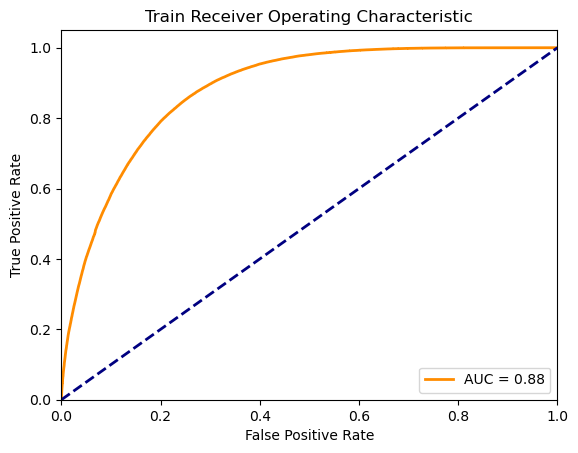

AUC-ROC: 0.88


In [40]:
print_classification_metrics(dataset='train')

Training Classification Report
              precision    recall  f1-score   support

           0       0.84      0.83      0.83     40733
           1       0.71      0.72      0.72     23953

    accuracy                           0.79     64686
   macro avg       0.77      0.77      0.77     64686
weighted avg       0.79      0.79      0.79     64686



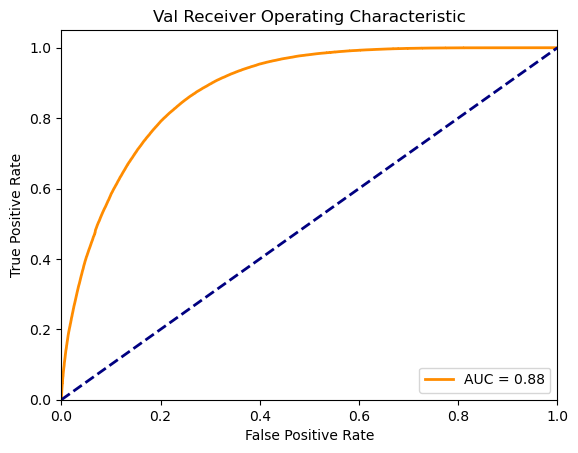

AUC-ROC: 0.88


In [41]:
print_classification_metrics(dataset='val')

Training Classification Report
              precision    recall  f1-score   support

           0       0.84      0.82      0.83     51026
           1       0.71      0.73      0.72     29832

    accuracy                           0.79     80858
   macro avg       0.77      0.78      0.77     80858
weighted avg       0.79      0.79      0.79     80858



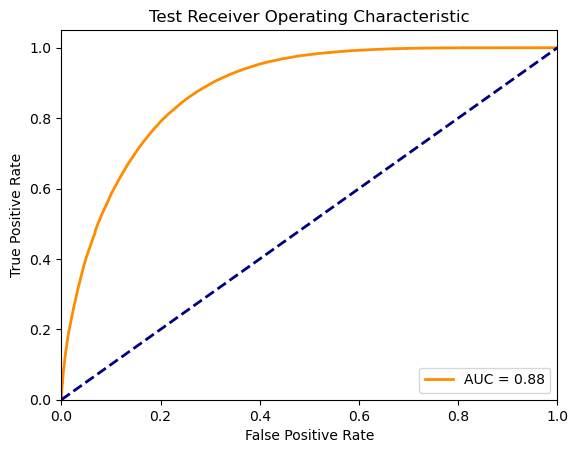

AUC-ROC: 0.88


In [42]:
print_classification_metrics(dataset='test')